In [9]:
# FIXME:第三部分：数据预处理与建模
# TODO:建模前的数据准备

# 在将数据喂给模型之前，我们必须进行最后的准备工作，确保数据是“干净”且“格式正确”的
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # 补充导入（原代码已使用np.log1p）


df = pd.read_csv('used_car_train_20200313.csv', sep=' ')

# 设置Pandas的显示选项，使其能够显示所有列和行
pd.set_option('display.max_columns', None) # 显示所有列
pd.set_option('display.max_rows', None)    # 显示所有行

# 设置中文字体，防止图表中的中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

In [10]:
# --- 通用数据预处理函数 ---
def preprocess_data(df, is_train=True, train_stats=None):
    df = df.copy()  # 避免修改原始数据

    # --- 日期转换与车龄计算 ---
    df['regDate'] = pd.to_datetime(df['regDate'], format='%Y%m%d', errors='coerce')
    df['creatDate'] = pd.to_datetime(df['creatDate'], format='%Y%m%d', errors='coerce')
    df['car_age'] = (df['creatDate'] - df['regDate']).dt.days / 365

    # --- 1. 处理缺失值 ---
    # 对于数值型特征，我们用中位数填充
    numeric_cols = ['car_age', 'power']
    for col in numeric_cols:
        if is_train:
            fill_value = df[col].median()  # 训练集用自身中位数
        else:
            fill_value = train_stats['numeric_medians'][col]  # 测试集用训练集的中位数
        df[col].fillna(fill_value, inplace=True)

    # 对于分类特征，我们用众数（出现次数最多的类别）填充
    categorical_cols = ['brand', 'gearbox', 'notRepairedDamage']
    for col in categorical_cols:
        if is_train:
            fill_value = df[col].mode()[0]  # 训练集用自身众数
        else:
            fill_value = train_stats['categorical_modes'][col]  # 测试集用训练集的众数
        df[col].fillna(fill_value, inplace=True)

    # 再次检查是否还有缺失值（仅训练集打印）
    if is_train:
        print("--- 填充后缺失值统计 ---")
        print(df.isnull().sum())

    # --- 2. 处理异常值 ---
    # 一个常见的异常是power（功率）为0，这不合逻辑。我们用中位数来替换它。顺便限制一下功率的最大值，比如小于600
    if is_train:
        power_median = df['power'].median()  # 训练集用自身中位数
    else:
        power_median = train_stats['power_median']  # 测试集用训练集的中位数
    df['power'] = df['power'].replace(0, power_median)
    df = df[df['power'] < 600]

    # --- 3. 特征变换 (对价格取对数) ---
    # 这是为了让价格分布更正态，有助于线性模型学习
    if 'price' in df.columns:  # 仅训练集有price列时执行
        df['log_price'] = np.log1p(df['price'])

    # --- 4. 特征编码 (独热编码) ---
    # 机器学习模型不认识'brand', 'bodyType'这些分类标签，需要把它们变成数字
    # 只对几个重要的分类特征进行编码
    categorical_features = ['brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage']
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    # drop_first=True是为了避免多重共线性问题，是独热编码的标准做法

    # 保存训练集统计量（供测试集使用）
    if is_train:
        train_stats = {
            'numeric_medians': {col: df[col].median() for col in numeric_cols},
            'categorical_modes': {col: df[col].mode()[0] for col in categorical_cols},
            'power_median': df['power'].median(),
            'encoded_columns': df_encoded.columns.tolist()  # 保存编码后的列名用于测试集对齐
        }
        return df_encoded, train_stats
    else:
        # 测试集特征对齐
        missing_cols = set(train_stats['encoded_columns']) - set(df_encoded.columns)
        for col in missing_cols:
            df_encoded[col] = 0  # 补全训练集有但测试集无的列
        df_encoded = df_encoded[train_stats['encoded_columns']]  # 列顺序对齐
        return df_encoded


In [11]:
# 使用预处理函数处理训练数据
df_encoded, train_stats = preprocess_data(df, is_train=True)

# 检查预处理后的数据
print("--- 预处理后的数据统计 ---")
print(df_encoded.isnull().sum())

# 查看编码后的数据
print("\n--- 编码后数据前5行预览 ---")
print(df_encoded.head())

--- 填充后缺失值统计 ---
SaleID                   0
name                     0
regDate              11347
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox                  0
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
car_age                  0
dtype: int64
--- 预处理后的数据统计 ---
SaleID                       0
name                         0
regDate                  1

C:\Users\34844\AppData\Local\Temp\ipykernel_39192\1061094744.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(fill_value, inplace=True)
C:\Users\34844\AppData\Local\Temp\ipykernel_39192\1061094744.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [12]:
# TODO:构建价格预测模型
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. 准备特征(X)和目标(y) ---
# 从编码后的数据中，选出所有我们认为是预测因子的列
# 注意：我们要预测的是log_price，所以原始的price和其他一些非数值列要去掉
drop_cols = [
    'price',  # 预测目标是log_price，原始price列不需要
    'log_price',
    'regDate',  # 日期类型列，不适合直接作为特征
    'creatDate',  # 日期类型列，不适合直接作为特征
    'SaleID',  # 唯一标识列，对预测无帮助
    'name',  # 车辆名称，对预测无帮助
    'seller',  # 卖方类型，从数据前几行看取值单一，无区分度
    'offerType'  # 报价类型，从数据前几行看取值单一，无区分度
]
X_train = df_encoded.drop(columns=drop_cols)
y_train = df_encoded['log_price'] # 变换后的log_price分布更接近于正态分布（钟形曲线），使得价格与其它变量之间的线性关系更易于被模型捕捉。在模型做出预测后，我们只需通过指数运算（exp(predicted_log_price)）即可将其还原为原始的价格预测值。

# 删除包含缺失值的行（为了训练模型时不报错）
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # 确保 y 和 X 的索引一致



# 检查 X 中是否存在缺失值
print("--- X 中的缺失值统计 ---")
print(X_train.isnull().sum())


--- X 中的缺失值统计 ---
model                    0
power                    0
kilometer                0
regionCode               0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
car_age                  0
brand_1                  0
brand_2                  0
brand_3                  0
brand_4                  0
brand_5                  0
brand_6                  0
brand_7                  0
brand_8                  0
brand_9                  0
brand_10                 0
brand_11                 0
brand_12                 0
brand_13                 0
brand_14                 0
brand_15                 0
brand_16                 0
brand_17  

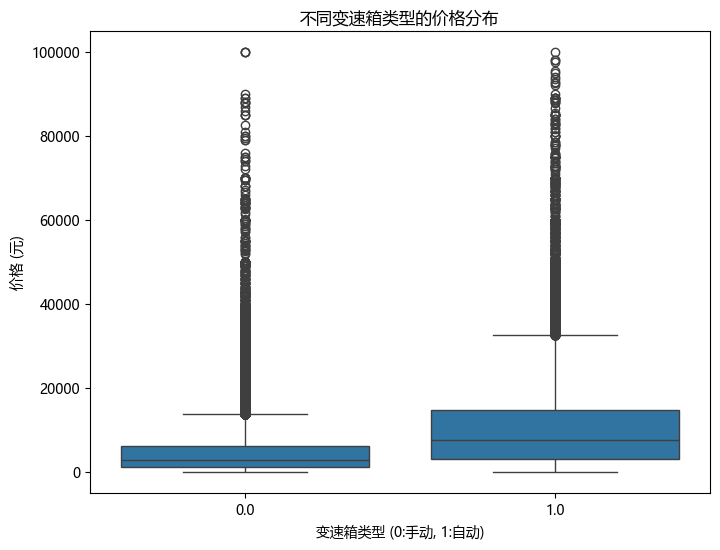

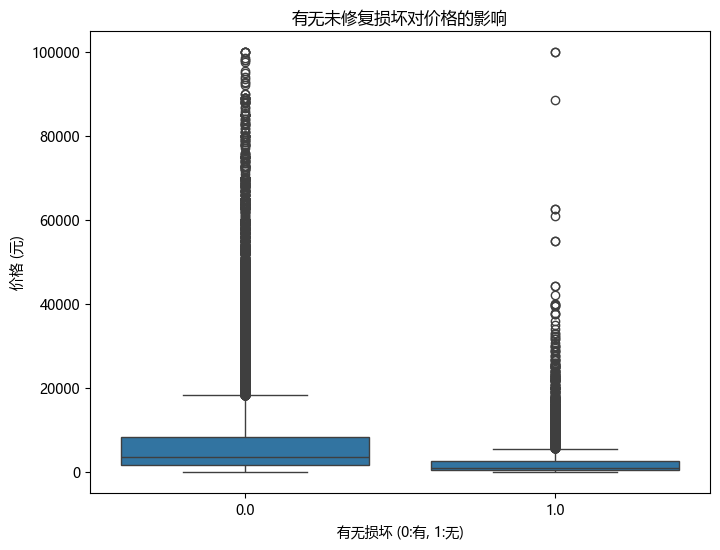

In [13]:
# --- 2. 变速箱(gearbox) vs 价格(price) ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='gearbox', y='price', data=df)
plt.title('不同变速箱类型的价格分布')
plt.xlabel('变速箱类型 (0:手动, 1:自动)')
plt.ylabel('价格 (元)')
plt.show()

# --- 3. 有无损坏(notRepairedDamage) vs 价格(price) ---
# 这个特征的值可能是字符串'0.0', '1.0', '-', 我们需要先统一处理
df['notRepairedDamage'] = df['notRepairedDamage'].replace('-', '0.0').astype(float)
plt.figure(figsize=(8, 6))
sns.boxplot(x='notRepairedDamage', y='price', data=df)
plt.title('有无未修复损坏对价格的影响')
plt.xlabel('有无损坏 (0:有, 1:无)')
plt.ylabel('价格 (元)')
plt.show()


In [14]:
# --- 2. 训练模型 ---
print("\n--- 开始训练模型 ---")

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 训练模型
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("--- 模型训练完成 ---")



--- 开始训练模型 ---
--- 模型训练完成 ---



--- 模型评估结果 ---
R-squared (R²): 0.9265
平均绝对误差 (MAE): 932.65 元
均方根误差 (RMSE): 1991.23 元


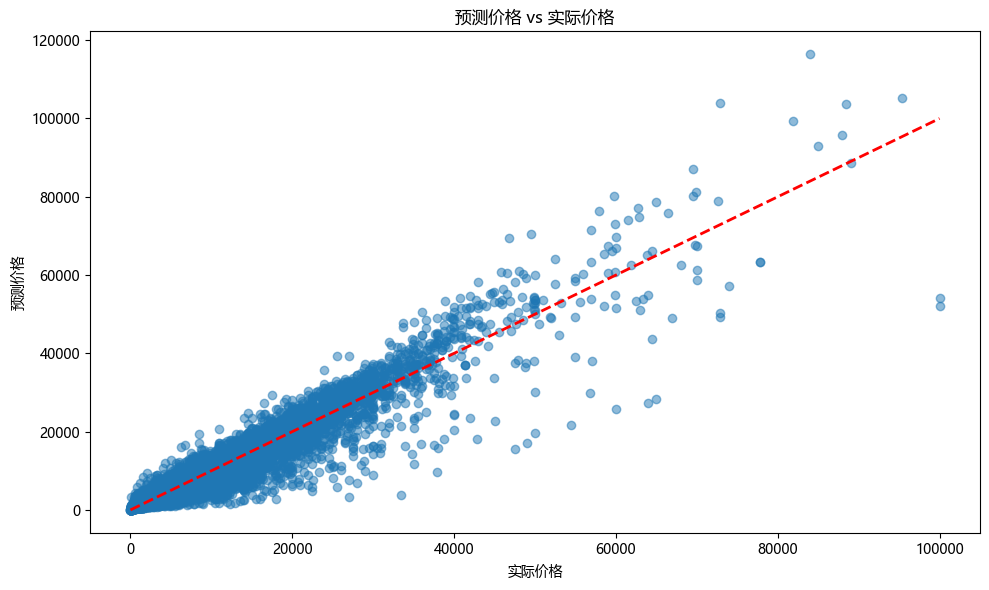

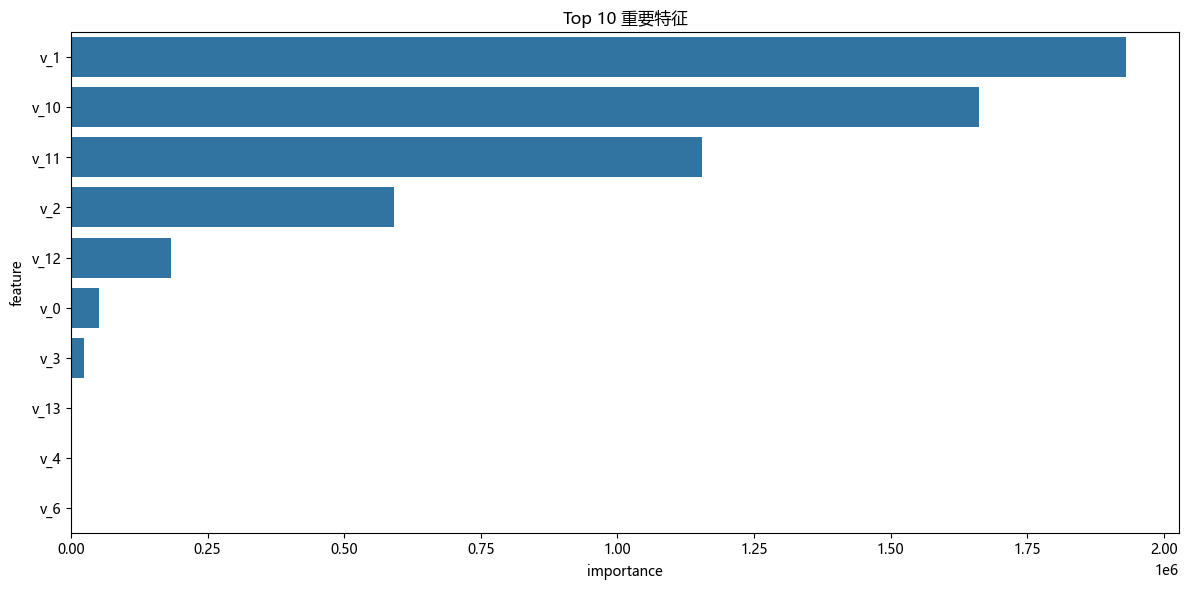

In [16]:
# FIXME:第四部分：结果评估与洞察提炼
# FIXME:模型评估与结果解读
# TODO:1：性能指标

# 在验证集上进行预测
y_pred_log = lr_model.predict(X_val_scaled)
y_pred = np.expm1(y_pred_log)
y_val_orig = np.expm1(y_val)

# 计算评估指标
r2 = r2_score(y_val_orig, y_pred)
mae = mean_absolute_error(y_val_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred))

print("\n--- 模型评估结果 ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"平均绝对误差 (MAE): {mae:.2f} 元")
print(f"均方根误差 (RMSE): {rmse:.2f} 元")

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.scatter(y_val_orig, y_pred, alpha=0.5)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--', lw=2)
plt.xlabel('实际价格')
plt.ylabel('预测价格')
plt.title('预测价格 vs 实际价格')
plt.tight_layout()
plt.show()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lr_model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 重要特征')
plt.tight_layout()
plt.show()

In [18]:
# TODO:2：结果解读：每个因素的影响有多大？

# 创建一个DataFrame来展示特征及其对应的回归系数
coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)
# 计算绝对值排序，方便看影响力最大的是谁
coeffs['Abs_Coefficient'] = coeffs['Coefficient'].abs()
coeffs = coeffs.sort_values(by='Abs_Coefficient', ascending=False)

print("\n--- 模型回归系数 ---")
print(coeffs.head(10)) # 查看正向影响最大的10个特征
print("\n")
print(coeffs.tail(10)) # 查看负向影响最大的10个特征

# 特别关注核心特征
print("\n--- 核心特征的影响 ---")
core_features = ['power', 'kilometer', 'car_age']
print(coeffs[coeffs['Feature'].isin(core_features)])



--- 模型回归系数 ---
   Feature   Coefficient  Abs_Coefficient
5      v_1  1.930894e+06     1.930894e+06
14    v_10  1.661649e+06     1.661649e+06
15    v_11 -1.154804e+06     1.154804e+06
6      v_2  5.917641e+05     5.917641e+05
16    v_12 -1.834428e+05     1.834428e+05
4      v_0  5.196330e+04     5.196330e+04
7      v_3 -2.448095e+04     2.448095e+04
17    v_13 -5.392762e+02     5.392762e+02
8      v_4  2.239579e+02     2.239579e+02
10     v_6 -9.239128e+00     9.239128e+00


         Feature  Coefficient  Abs_Coefficient
30      brand_11     0.001029         0.001029
69  fuelType_4.0    -0.000956         0.000956
58      brand_39     0.000799         0.000799
52      brand_33    -0.000745         0.000745
42      brand_23     0.000693         0.000693
49      brand_30    -0.000166         0.000166
59  bodyType_1.0    -0.000111         0.000111
27       brand_8    -0.000062         0.000062
24       brand_5    -0.000036         0.000036
70  fuelType_5.0    -0.000022         0.000022

--